<a href="https://colab.research.google.com/github/VzTong/LungCancerDx_TrainModels/blob/main/LungCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kết nối với dataset trên Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Kiểm tra dữ liệu trong thư mục LungCancerDx
dataset_path = "/content/drive/MyDrive/Colab Notebooks/LungCancerDx/TFRecords"
!ls "{dataset_path}"

# Chạy trên mail khác
# Dataset đã được chia sẻ -> tạo một shortcut và sử dụng

test_dataset.tfrecord  train_dataset.tfrecord  val_dataset.tfrecord


# Kiểm tra chiều của thư mục dạng .npy
Kiểm tra trước khi chuyển đổi dữ liệu

In [ ]:
import os
import numpy as np

# Định nghĩa thư mục và danh sách lớp
normalized_npy_path = "/content/drive/MyDrive/Colab Notebooks/LungCancerDx/NormalizedNpyLungDiseaseDataset"
splits = ["train", "test", "val"]
classes = ["Normal", "Bacterial Pneumonia", "Corona Virus Disease", "Tuberculosis", "Viral Pneumonia"]

# Hàm kiểm tra shape của file .npy
def check_npy_shapes():
    """Kiểm tra shape của các file .npy trong thư mục."""
    for split in splits:
        print(f"\nKiểm tra split: {split}")
        for cls in classes:
            folder = os.path.join(normalized_npy_path, split, cls)
            if os.path.exists(folder):
                print(f"  Class: {cls}")
                file_names = [f for f in os.listdir(folder) if f.endswith('.npy')]
                if not file_names:
                    print("    Không có file .npy nào trong thư mục!")
                    continue
                # Kiểm tra shape của file đầu tiên trong thư mục
                for file_name in file_names[:3]:  # Chỉ kiểm tra 3 file đầu tiên để tiết kiệm thời gian
                    file_path = os.path.join(folder, file_name)
                    array = np.load(file_path)
                    print(f"    File: {file_name}, Shape: {array.shape}")
            else:
                print(f"  Thư mục {cls} không tồn tại!")

# Chạy kiểm tra
if __name__ == "__main__":
    check_npy_shapes()


Kiểm tra split: train
  Class: Normal
    File: IM-0420-0001.jpeg.npy, Shape: (224, 224)
    File: IM-0423-0001.jpeg.npy, Shape: (224, 224)
    File: IM-0427-0001.jpeg.npy, Shape: (224, 224)
  Class: Bacterial Pneumonia
    File: 560.jpeg.npy, Shape: (224, 224)
    File: 561.jpeg.npy, Shape: (224, 224)
    File: 562.jpeg.npy, Shape: (224, 224)
  Class: Corona Virus Disease
    File: 00030536_005.png.npy, Shape: (224, 224)
    File: 00030536_007.png.npy, Shape: (224, 224)
    File: 00030537_000.png.npy, Shape: (224, 224)
  Class: Tuberculosis
    File: Tuberculosis-46.npy, Shape: (224, 224)
    File: Tuberculosis-460.npy, Shape: (224, 224)
    File: Tuberculosis-461.npy, Shape: (224, 224)
  Class: Viral Pneumonia
    File: VIRUS-2965742-0002.jpeg.npy, Shape: (224, 224)
    File: VIRUS-2968130-0001.jpeg.npy, Shape: (224, 224)
    File: VIRUS-2968130-0002.jpeg.npy, Shape: (224, 224)

Kiểm tra split: test
  Class: Normal
    File: 01.jpeg.npy, Shape: (224, 224)
    File: 0105.jpeg.npy, Sh

# Chuyển đổi dữ liệu từ các file .npy trong thư mục NormalizedNpyLungDiseaseDataset sang định dạng TFRecord

Sau đó load và sử dụng TFRecord để tạo tf.data.Dataset cho việc huấn luyện CNN.

Định dạng TFRecord được tối ưu hóa cho I/O trong TensorFlow, giúp tăng tốc độ load dữ liệu và giảm tài nguyên khi huấn luyện, đặc biệt với dữ liệu lớn.

> Mixed Precision: Kích hoạt để tăng tốc huấn luyện

> Chuyển đổi dữ liệu .npy sang TFRecord: Lưu trữ dữ liệu ảnh (mảng numpy) và nhãn thành các file TFRecord cho từng tập (train, val, test).

> Tạo tf.data.Dataset từ TFRecord: Load dữ liệu từ file TFRecord và tối ưu hóa pipeline.

> Compressed TFRecord: Sử dụng nén để giảm kích thước file

> Sử dụng trong huấn luyện: Sử dụng dataset đã tạo để huấn luyện mô hình CNN.

In [ ]:
import os
import numpy as np
import tensorflow as tf
import random

# Kích hoạt Mixed Precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("Mixed Precision đã được kích hoạt!")

# Định nghĩa thư mục và danh sách lớp
normalized_npy_path = "/content/drive/MyDrive/Colab Notebooks/LungCancerDx/NormalizedNpyLungDiseaseDataset"
splits = ["train", "test", "val"]
classes = ["Normal", "Bacterial Pneumonia", "Corona Virus Disease", "Tuberculosis", "Viral Pneumonia"]
output_dir = "/content/drive/MyDrive/Colab Notebooks/LungCancerDx/TFRecords"

# Tạo thư mục output nếu chưa tồn tại
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Hàm kiểm tra shape của file .npy
def check_npy_shapes():
    # Kiểm tra shape của các file .npy trong thư mục.
    for split in splits:
        print(f"\nKiểm tra split: {split}")
        for cls in classes:
            folder = os.path.join(normalized_npy_path, split, cls)
            if os.path.exists(folder):
                print(f"  Class: {cls}")
                file_names = [f for f in os.listdir(folder) if f.endswith('.npy')]
                if not file_names:
                    print("    Không có file .npy nào trong thư mục!")
                    continue
                for file_name in file_names[:3]:
                    file_path = os.path.join(folder, file_name)
                    array = np.load(file_path)
                    print(f"    File: {file_name}, Shape: {array.shape}")
            else:
                print(f"  Thư mục {cls} không tồn tại!")

# Hàm kiểm tra phân bố nhãn
def check_label_distribution(datasets):
    # Kiểm tra phân bố nhãn trong từng split.
    for split in splits:
        _, labels = datasets[split]
        print(f"\nPhân bố nhãn trong split {split}:")
        unique_labels, counts = np.unique(labels, return_counts=True)
        for label, count in zip(unique_labels, counts):
            print(f"  Class {classes[label]} (Label {label}): {count} mẫu")

# Hàm tạo feature cho TFRecord
def _bytes_feature(value):
    # Returns a bytes_list from a string / byte.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    # Returns an int64_list from a bool / enum / int / uint.
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# Hàm chuyển đổi file .npy thành TFRecord với nén GZIP
def create_tfrecord_from_npy(file_paths, labels, output_path):
    # Chuyển đổi danh sách file .npy và nhãn thành file TFRecord với nén GZIP.
    # Xáo trộn file paths và labels trước khi lưu vào TFRecord
    combined = list(zip(file_paths, labels))
    random.shuffle(combined)
    file_paths, labels = zip(*combined)

    options = tf.io.TFRecordOptions(compression_type="GZIP")
    with tf.io.TFRecordWriter(output_path, options=options) as writer:
        for file_path, label in zip(file_paths, labels):
            array = np.load(file_path)
            if len(array.shape) == 2:
                array = np.expand_dims(array, axis=-1)
            array_bytes = array.tobytes()
            feature = {
                'image': _bytes_feature(array_bytes),
                'label': _int64_feature(label),
                'height': _int64_feature(array.shape[0]),
                'width': _int64_feature(array.shape[1]),
                'channels': _int64_feature(array.shape[2]),
            }
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())
    print(f"Đã tạo file TFRecord (nén GZIP): {output_path}")

# Hàm lấy danh sách file .npy và nhãn
def get_npy_paths_and_labels():
    # Lấy danh sách đường dẫn file .npy và nhãn từ thư mục, phân theo splits.
    datasets = {}
    label_map = {cls: idx for idx, cls in enumerate(classes)}

    for split in splits:
        file_paths = []
        labels = []
        for cls in classes:
            folder = os.path.join(normalized_npy_path, split, cls)
            if os.path.exists(folder):
                for file_name in os.listdir(folder):
                    if file_name.endswith('.npy'):
                        file_paths.append(os.path.join(folder, file_name))
                        labels.append(label_map[cls])
        datasets[split] = (file_paths, labels)

    return datasets

# Hàm phân tích TFRecord
def parse_tfrecord_fn(example):
    # Phân tích một example từ TFRecord.
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'channels': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_raw(example['image'], tf.float32)
    height = tf.cast(example['height'], tf.int32)
    width = tf.cast(example['width'], tf.int32)
    channels = tf.cast(example['channels'], tf.int32)
    image = tf.reshape(image, [height, width, channels])
    label = tf.cast(example['label'], tf.int32)
    return image, label

# Hàm tạo dataset từ TFRecord
def create_tf_dataset(tfrecord_path, batch_size=32, shuffle=True):
    # Tạo tf.data.Dataset từ file TFRecord (hỗ trợ nén GZIP).
    dataset = tf.data.TFRecordDataset(tfrecord_path, compression_type="GZIP")
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=5000)  # Tăng buffer_size để xáo trộn tốt hơn
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Main: Kiểm tra shape, kiểm tra nhãn, chuyển đổi sang TFRecord và tạo dataset
if __name__ == "__main__":
    # Bước 1: Kiểm tra shape của file .npy
    print("Kiểm tra shape của các file .npy:")
    check_npy_shapes()

    # Bước 2: Lấy danh sách file .npy và nhãn
    datasets = get_npy_paths_and_labels()

    # Bước 3: Kiểm tra phân bố nhãn
    print("\nKiểm tra phân bố nhãn:")
    check_label_distribution(datasets)

    # Bước 4: Chuyển đổi sang TFRecord
    for split in splits:
        file_paths, labels = datasets[split]
        if file_paths:
            output_path = os.path.join(output_dir, f"{split}_dataset.tfrecord")
            create_tfrecord_from_npy(file_paths, labels, output_path)
        else:
            print(f"Không có dữ liệu trong split {split}")

    # Bước 5: Tạo và kiểm tra dataset từ TFRecord
    for split in splits:
        tfrecord_path = os.path.join(output_dir, f"{split}_dataset.tfrecord")
        if os.path.exists(tfrecord_path):
            dataset = create_tf_dataset(tfrecord_path, batch_size=32, shuffle=(split == "train"))
            print(f"\nĐã tạo dataset cho {split}:")
            for i, (images, labels) in enumerate(dataset.take(3)):  # Kiểm tra 3 batch
                print(f"Batch {i+1} - Kích thước batch ảnh ({split}):", images.shape)
                print(f"Batch {i+1} - Nhãn trong batch ({split}):", labels.numpy())
        else:
            print(f"File TFRecord cho {split} không tồn tại!")

    print("\nHoàn tất chuyển đổi sang TFRecord và tạo dataset!")

Mixed Precision đã được kích hoạt!
Kiểm tra shape của các file .npy:

Kiểm tra split: train
  Class: Normal
    File: IM-0420-0001.jpeg.npy, Shape: (224, 224)
    File: IM-0423-0001.jpeg.npy, Shape: (224, 224)
    File: IM-0427-0001.jpeg.npy, Shape: (224, 224)
  Class: Bacterial Pneumonia
    File: 560.jpeg.npy, Shape: (224, 224)
    File: 561.jpeg.npy, Shape: (224, 224)
    File: 562.jpeg.npy, Shape: (224, 224)
  Class: Corona Virus Disease
    File: 00030536_005.png.npy, Shape: (224, 224)
    File: 00030536_007.png.npy, Shape: (224, 224)
    File: 00030537_000.png.npy, Shape: (224, 224)
  Class: Tuberculosis
    File: Tuberculosis-46.npy, Shape: (224, 224)
    File: Tuberculosis-460.npy, Shape: (224, 224)
    File: Tuberculosis-461.npy, Shape: (224, 224)
  Class: Viral Pneumonia
    File: VIRUS-2965742-0002.jpeg.npy, Shape: (224, 224)
    File: VIRUS-2968130-0001.jpeg.npy, Shape: (224, 224)
    File: VIRUS-2968130-0002.jpeg.npy, Shape: (224, 224)

Kiểm tra split: test
  Class: Normal

# Code sử dụng file dataset cho các lần chạy tiếp theo

## Kiểm tra shape và giá trị pixel của các file .npy:

In [ ]:
import os
import numpy as np
import tensorflow as tf
import random

# Kích hoạt Mixed Precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("Mixed Precision đã được kích hoạt!")

# Định nghĩa thư mục và danh sách lớp
normalized_npy_path = "/content/drive/MyDrive/Colab Notebooks/LungCancerDx/NormalizedNpyLungDiseaseDataset"
splits = ["train", "test", "val"]
classes = ["Normal", "Bacterial Pneumonia", "Corona Virus Disease", "Tuberculosis", "Viral Pneumonia"]
output_dir = "/content/drive/MyDrive/Colab Notebooks/LungCancerDx/TFRecords"

# Hàm kiểm tra shape và giá trị pixel của file .npy
def check_npy_shapes_and_values():
    # Kiểm tra shape và giá trị pixel của các file .npy trong thư mục.
    for split in splits:
        print(f"\nKiểm tra split: {split}")
        for cls in classes:
            folder = os.path.join(normalized_npy_path, split, cls)
            if os.path.exists(folder):
                print(f"  Class: {cls}")
                file_names = [f for f in os.listdir(folder) if f.endswith('.npy')]
                if not file_names:
                    print("    Không có file .npy nào trong thư mục!")
                    continue
                for file_name in file_names[:3]:  # Kiểm tra 3 file đầu tiên
                    file_path = os.path.join(folder, file_name)
                    array = np.load(file_path)
                    print(f"    File: {file_name}, Shape: {array.shape}, Min: {array.min()}, Max: {array.max()}")
            else:
                print(f"  Thư mục {cls} không tồn tại!")

# Thêm vào main
if __name__ == "__main__":
    # Bước 1: Kiểm tra shape và giá trị pixel của file .npy
    print("Kiểm tra shape và giá trị pixel của các file .npy:")
    check_npy_shapes_and_values()
    # (Tiếp tục các bước khác như trước)

Mixed Precision đã được kích hoạt!
Kiểm tra shape và giá trị pixel của các file .npy:

Kiểm tra split: train
  Class: Normal
    File: IM-0420-0001.jpeg.npy, Shape: (224, 224), Min: 0.0, Max: 0.9803921580314636
    File: IM-0423-0001.jpeg.npy, Shape: (224, 224), Min: 0.0, Max: 0.9882352948188782
    File: IM-0427-0001.jpeg.npy, Shape: (224, 224), Min: 0.0, Max: 1.0
  Class: Bacterial Pneumonia
    File: 560.jpeg.npy, Shape: (224, 224), Min: 0.0, Max: 0.8156862854957581
    File: 561.jpeg.npy, Shape: (224, 224), Min: 0.0, Max: 1.0
    File: 562.jpeg.npy, Shape: (224, 224), Min: 0.0, Max: 0.9803921580314636
  Class: Corona Virus Disease
    File: 00030536_005.png.npy, Shape: (224, 224), Min: 0.0, Max: 0.6352941393852234
    File: 00030536_007.png.npy, Shape: (224, 224), Min: 0.0, Max: 0.8392156958580017
    File: 00030537_000.png.npy, Shape: (224, 224), Min: 0.0, Max: 0.6431372761726379
  Class: Tuberculosis
    File: Tuberculosis-46.npy, Shape: (224, 224), Min: 0.0, Max: 0.7843137383460

## Load dataset từ TFRecord

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import mixed_precision

# Kích hoạt Mixed Precision
mixed_precision.set_global_policy('mixed_float16')
print("Mixed Precision đã được kích hoạt!")

# Định nghĩa đường dẫn đến thư mục chứa file TFRecord
output_dir = "/content/drive/MyDrive/Colab Notebooks/LungCancerDx/TFRecords"
splits = ["train", "test", "val"]

# Hàm phân tích TFRecord
def parse_tfrecord_fn(example):
    # Phân tích một example từ TFRecord.
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'channels': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_raw(example['image'], tf.float32)
    height = tf.cast(example['height'], tf.int32)
    width = tf.cast(example['width'], tf.int32)
    channels = tf.cast(example['channels'], tf.int32)
    image = tf.reshape(image, [height, width, channels])
    label = tf.cast(example['label'], tf.int32)
    return image, label

# Hàm tạo dataset từ TFRecord
def create_tf_dataset(tfrecord_path, batch_size=32, shuffle=True):
    # Tạo tf.data.Dataset từ file TFRecord (hỗ trợ nén GZIP).
    dataset = tf.data.TFRecordDataset(tfrecord_path, compression_type="GZIP")
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=5000)  # Buffer size lớn để xáo trộn tốt
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
     # Kiểm tra giá trị pixel của batch đầu tiên
    for images, labels in dataset.take(1):
        print(f"Kiểm tra giá trị pixel trong batch đầu tiên: Min: {tf.reduce_min(images).numpy()}, Max: {tf.reduce_max(images).numpy()}")
    return dataset

# Load dataset từ TFRecord
train_dataset = create_tf_dataset(os.path.join(output_dir, "train_dataset.tfrecord"), batch_size=32, shuffle=True)
val_dataset = create_tf_dataset(os.path.join(output_dir, "val_dataset.tfrecord"), batch_size=32, shuffle=False)
test_dataset = create_tf_dataset(os.path.join(output_dir, "test_dataset.tfrecord"), batch_size=32, shuffle=False)

# Kiểm tra dataset
print("\nKiểm tra dataset:")
for split, dataset in [("train", train_dataset), ("val", val_dataset), ("test", test_dataset)]:
    print(f"\nĐã tạo dataset cho {split}:")
    for i, (images, labels) in enumerate(dataset.take(3)):  # Kiểm tra 3 batch
        print(f"Batch {i+1} - Kích thước batch ảnh ({split}):", images.shape)
        print(f"Batch {i+1} - Nhãn trong batch ({split}):", labels.numpy())

print("\nHoàn tất load dataset từ TFRecord!")

Mixed Precision đã được kích hoạt!
Kiểm tra giá trị pixel trong batch đầu tiên: Min: 0.0, Max: 1.0
Kiểm tra giá trị pixel trong batch đầu tiên: Min: 0.0, Max: 1.0
Kiểm tra giá trị pixel trong batch đầu tiên: Min: 0.0, Max: 1.0

Kiểm tra dataset:

Đã tạo dataset cho train:
Batch 1 - Kích thước batch ảnh (train): (32, 224, 224, 1)
Batch 1 - Nhãn trong batch (train): [4 2 4 3 2 2 4 0 2 2 4 3 3 1 3 4 1 2 3 1 1 1 0 4 2 0 1 2 3 3 0 2]
Batch 2 - Kích thước batch ảnh (train): (32, 224, 224, 1)
Batch 2 - Nhãn trong batch (train): [0 1 2 4 0 0 2 0 0 2 2 3 1 3 0 0 3 3 2 2 1 3 3 1 0 3 4 3 0 2 2 3]
Batch 3 - Kích thước batch ảnh (train): (32, 224, 224, 1)
Batch 3 - Nhãn trong batch (train): [1 0 2 0 4 4 0 0 1 3 0 1 3 2 0 3 4 4 3 2 3 1 4 1 2 0 1 3 4 4 1 2]

Đã tạo dataset cho val:
Batch 1 - Kích thước batch ảnh (val): (32, 224, 224, 1)
Batch 1 - Nhãn trong batch (val): [4 4 2 3 4 0 4 4 4 4 3 3 1 2 0 0 3 2 1 2 3 0 4 2 2 1 4 0 3 4 3 0]
Batch 2 - Kích thước batch ảnh (val): (32, 224, 224, 1)
Batch 2 - 

# Thực hiện huấn luyện cho models CNN

Cải thiện mô hình

Tách nền hiệu quả hơn bằng cách kết hợp ngưỡng động, phép toán hình thái, và phân tích không gian.

Tích hợp CBAM, điều chỉnh regularization, tăng cường data augmentation, và Grad-CAM.

> Lý do không dùng U-NET: U-NET yêu cầu cần có mặt nạ phân vùng, ở đây vì là ảnh x-quang phổi, và bài toán là phân loại bệnh của phổi => các thành phần mà bài toán phải học liên quan đến cả xương, đường khí quản, cơ hoành, tim,... Nên nếu muốn dùng U-NET cần phải phân đoạn nhiều vùng (Multi-Region Segmentation), để có thể trích xuất đặc trưng từ chúng

=> Dữ liệu chuyên môn không có sẵn, và nếu muốn làm thủ công -> không đủ thời gian, và không đủ chuyên môn y khoa để hiểu rõ, vẽ chính xác

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras import mixed_precision
import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Kích hoạt Mixed Precision để tăng tốc huấn luyện
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print("Mixed Precision Policy:", mixed_precision.global_policy())
# => Sử dụng mixed precision (float16) để tăng tốc độ huấn luyện và giảm sử dụng bộ nhớ trên GPU.

# Định nghĩa số lượng lớp
classes = ["Normal", "Bacterial Pneumonia", "Corona Virus Disease", "Tuberculosis", "Viral Pneumonia"]
num_classes = len(classes)
# => Danh sách 5 lớp bệnh phổi mà mô hình sẽ phân loại.

# Định nghĩa mô-đun CBAM
def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    shared_layer_one = layers.Dense(channel // ratio, activation='relu', use_bias=True)
    shared_layer_two = layers.Dense(channel, use_bias=True)

    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = layers.GlobalMaxPooling2D()(input_feature)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = layers.Add()([avg_pool, max_pool])
    cbam_feature = layers.Activation('sigmoid')(cbam_feature)

    return layers.Multiply()([input_feature, cbam_feature])
# => Channel Attention xác định các kênh quan trọng trong ảnh bằng cách kết hợp pooling trung bình và tối đa.

def spatial_attention(input_feature, block_id):
    kernel_size = 7

    # Sử dụng keras.ops thay vì tf.reduce_mean và tf.reduce_max
    avg_pool = keras.ops.mean(input_feature, axis=-1, keepdims=True)
    max_pool = keras.ops.max(input_feature, axis=-1, keepdims=True)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])

    # Tạo tên duy nhất dựa trên block_id
    cbam_feature = layers.Conv2D(
        filters=1,
        kernel_size=kernel_size,
        strides=1,
        padding='same',
        activation='sigmoid',
        use_bias=False,
        name=f'spatial_attention_conv_block{block_id}'
    )(concat)

    return layers.Multiply()([input_feature, cbam_feature])
# => Spatial Attention tập trung vào các vùng không gian quan trọng trên ảnh.

def cbam_block(input_feature, ratio=8, block_id=None):
    if block_id is None:
        raise ValueError("block_id must be provided to cbam_block to ensure unique layer names.")

    cbam_feature = channel_attention(input_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature, block_id)
    return cbam_feature
# => CBAM kết hợp Channel và Spatial Attention để tăng khả năng tập trung vào đặc trưng quan trọng.

# Hàm tính ngưỡng Otsu bằng TensorFlow
def otsu_threshold(image):
    # Chuẩn hóa ảnh về [0, 1]
    image = (image - tf.reduce_min(image)) / (tf.reduce_max(image) - tf.reduce_min(image))

    # Đưa về khoảng [0, 255] nhưng giữ kiểu float32
    image_scaled = image * 255.0

    # Tính histogram
    hist = tf.histogram_fixed_width(image_scaled, [0.0, 256.0], nbins=256)
    hist = tf.cast(hist, tf.float32)

    # Tính các giá trị cần thiết cho Otsu
    bin_centers = tf.range(256, dtype=tf.float32)
    total = tf.reduce_sum(hist)
    weight_background = tf.cumsum(hist)
    weight_foreground = total - weight_background

    # Tránh chia cho 0
    weight_background = tf.where(weight_background == 0, tf.ones_like(weight_background), weight_background)
    weight_foreground = tf.where(weight_foreground == 0, tf.ones_like(weight_foreground), weight_foreground)

    mean_background = tf.cumsum(hist * bin_centers) / weight_background
    mean_foreground = (tf.reduce_sum(hist * bin_centers) - tf.cumsum(hist * bin_centers)) / weight_foreground

    # Tính phương sai giữa các lớp (between-class variance)
    class_variance = weight_background * weight_foreground * (mean_background - mean_foreground) ** 2
    threshold = tf.argmax(class_variance)

    # Áp dụng ngưỡng
    binary_mask = tf.cast(image_scaled >= tf.cast(threshold, tf.float32), tf.float32)
    return binary_mask
# => Tính ngưỡng Otsu để tách nền và tiền cảnh trong ảnh X-quang.

# Hàm tách nền bằng TensorFlow thuần
def preprocess_image(image, label, augment=False):
    # Resize ảnh
    image = tf.image.resize(image, [224, 224])

    # Chuẩn hóa (zero-mean, unit-variance)
    image = (image - tf.reduce_mean(image)) / tf.math.reduce_std(image)

    # Tách nền bằng ngưỡng động (Otsu)
    # Lấy kênh đầu tiên (ảnh X-quang là 1 kênh)
    img_for_threshold = image[:, :, 0]
    binary_mask = otsu_threshold(img_for_threshold)

    # Áp dụng phép toán hình thái (dilation, erosion)
    # Tạo kernel 5x5
    kernel = tf.ones((5, 5, 1), dtype=tf.float32)

    # Dilation
    binary_mask = tf.expand_dims(binary_mask, axis=0)  # Thêm batch dimension
    binary_mask = tf.expand_dims(binary_mask, axis=-1)  # Thêm channel dimension
    binary_mask = tf.nn.dilation2d(
        binary_mask,
        filters=kernel,
        strides=(1, 1, 1, 1),
        padding="SAME",
        data_format="NHWC",
        dilations=(1, 1, 1, 1)
    )
    binary_mask = tf.squeeze(binary_mask, axis=0)  # Loại bỏ batch dimension

    # Erosion
    binary_mask = tf.expand_dims(binary_mask, axis=0)  # Thêm lại batch dimension
    binary_mask = tf.nn.erosion2d(
        binary_mask,
        filters=kernel,
        strides=(1, 1, 1, 1),
        padding="SAME",
        data_format="NHWC",
        dilations=(1, 1, 1, 1)
    )
    binary_mask = tf.squeeze(binary_mask, axis=0)  # Loại bỏ batch dimension

    # Áp dụng mask lên ảnh
    mask = binary_mask  # Sửa lỗi: sử dụng binary_mask thay vì mask
    image = image * mask  # Shape của image và mask đều là (224, 224, 1)

    # Đặt shape cố định cho image
    image.set_shape([224, 224, 1])

    if augment:
        # Lật ngang (an toàn cho ảnh X-quang)
        image = tf.image.random_flip_left_right(image)

    return image, label
# => Tiền xử lý ảnh bao gồm resize, chuẩn hóa, tách nền bằng Otsu và tăng cường dữ liệu (lật ngang nếu bật augment).

# Hàm phân tích TFRecord
def parse_tfrecord_fn(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'channels': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_raw(example['image'], tf.float32)
    height = tf.cast(example['height'], tf.int32)
    width = tf.cast(example['width'], tf.int32)
    channels = tf.cast(example['channels'], tf.int32)

    image = tf.reshape(image, [height, width, channels])
    if tf.math.equal(channels, 1):
        pass
    else:
        tf.print(f"Warning: Channels is {channels}, forcing to 1")
        image = tf.reduce_mean(image, axis=-1, keepdims=True)

    image = tf.ensure_shape(image, [None, None, 1])
    label = tf.cast(example['label'], tf.int32)
    return image, label
# => Đọc và phân tích dữ liệu từ file TFRecord, đảm bảo ảnh có 1 kênh.

# Hàm tạo dataset từ TFRecord
def create_tf_dataset(tfrecord_path, batch_size=32, shuffle=True, augment=False):
    dataset = tf.data.TFRecordDataset(tfrecord_path, compression_type="GZIP")
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=5000)

    # Áp dụng tiền xử lý và data augmentation
    dataset = dataset.map(
        lambda x, y: preprocess_image(x, y, augment=augment),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Thêm dịch chuyển nhỏ (translation) nếu augment=True
    if augment:
        # Dịch chuyển ngẫu nhiên trong khoảng ±10% chiều cao và chiều rộng
        translation_layer = tf.keras.layers.RandomTranslation(
            height_factor=0.1,  # Dịch chuyển tối đa 10% chiều cao
            width_factor=0.1,   # Dịch chuyển tối đa 10% chiều rộng
            fill_mode='nearest'
        )
        dataset = dataset.map(
            lambda x, y: (translation_layer(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    for images, labels in dataset.take(1):
        print(f"Shape of images after preprocess: {images.shape}")

    return dataset
# => Tạo dataset từ TFRecord với tiền xử lý và tăng cường dữ liệu (dịch chuyển nếu bật augment).

# Load dataset
output_dir = "/content/drive/MyDrive/Colab Notebooks/LungCancerDx/TFRecords"
train_dataset = create_tf_dataset(os.path.join(output_dir, "train_dataset.tfrecord"), batch_size=32, shuffle=True, augment=True)
val_dataset = create_tf_dataset(os.path.join(output_dir, "val_dataset.tfrecord"), batch_size=32, shuffle=False, augment=False)
test_dataset = create_tf_dataset(os.path.join(output_dir, "test_dataset.tfrecord"), batch_size=32, shuffle=False, augment=False)

# Tính số bước mỗi epoch
train_steps = 190
val_steps = 64
# => Tải dữ liệu từ Google Drive và xác định số bước huấn luyện/xác thực mỗi epoch.

# Xây dựng mô hình CNN với CBAM
def create_cnn_model_with_cbam(num_classes=5):
    inputs = layers.Input(shape=(224, 224, 1))

    # Convolutional Block 1
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), name='conv2d_block1_1')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), name='conv2d_block1_2')(x)
    x = layers.BatchNormalization()(x)
    x = cbam_block(x, block_id=1)
    x = layers.MaxPooling2D((2, 2))(x)

    # Convolutional Block 2
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), name='conv2d_block2_1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), name='conv2d_block2_2')(x)
    x = layers.BatchNormalization()(x)
    x = cbam_block(x, block_id=2)
    x = layers.MaxPooling2D((2, 2))(x)

    # Convolutional Block 3
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), name='conv2d_block3_1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), name='conv2d_block3_2')(x)
    x = layers.BatchNormalization()(x)
    x = cbam_block(x, block_id=3)
    x = layers.MaxPooling2D((2, 2))(x)

    # Flatten và Dense Layers
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.6)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.6)(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = models.Model(inputs, outputs)
    return model
# => Mô hình CNN với 3 khối convolution tích hợp CBAM, sau đó là các tầng Dense để phân loại.

# Tạo và biên dịch mô hình
model = create_cnn_model_with_cbam(num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Hiển thị tóm tắt mô hình
model.summary()
# => Biên dịch mô hình với Adam optimizer, hàm mất mát sparse_categorical_crossentropy và đo độ chính xác.

# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)
# => Các callback để lưu mô hình tốt nhất, dừng sớm nếu không cải thiện, và giảm learning rate khi cần.

# Huấn luyện mô hình
history = model.fit(
    train_dataset.repeat(),
    validation_data=val_dataset.repeat(),
    epochs=50,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)
# => Huấn luyện mô hình trong 50 epoch với dữ liệu lặp lại để đảm bảo đủ bước.

# Đánh giá mô hình trên tập test
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"\nĐộ chính xác trên tập test: {test_accuracy*100:.2f}%")
# => Đánh giá độ chính xác của mô hình trên tập kiểm tra.

# Vẽ và lưu biểu đồ độ chính xác và loss
plt.figure(figsize=(12, 4))

# Biểu đồ accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Biểu đồ loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('training_plots.png', dpi=300, bbox_inches='tight')
plt.close()
# => Vẽ biểu đồ độ chính xác và mất mát, sau đó lưu thành file PNG với độ phân giải cao.

# Confusion Matrix
y_true = []
y_pred = []
for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.close()
# => Tạo và lưu ma trận nhầm lẫn, hiển thị số lượng dự đoán đúng/sai cho từng lớp.

print("\nĐã lưu biểu đồ training plots vào 'training_plots.png'")
print("Đã lưu confusion matrix vào 'confusion_matrix.png'")
# => In thông báo xác nhận đã lưu file.

Mixed Precision Policy: <DTypePolicy "mixed_float16">
Shape of images after preprocess: (32, 224, 224, 1)
Shape of images after preprocess: (32, 224, 224, 1)
Shape of images after preprocess: (32, 224, 224, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 224, 224, 1)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_block1_1 (Conv2D)  │ (None, 224, 224, 64)   │            640 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 64)   │            256 │ conv2d_block1_1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_block1_2 (Conv2D)  │ (None, 224, 224, 64)   │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 64)   │            256 │ conv2d_block1_2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ batch_normalization_1… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d      │ (None, 64)             │              0 │ batch_normalization_1… │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 64)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 1, 64)       │              0 │ global_max_pooling2d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 1, 8)        │            520 │ reshape[0][0],         │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 1, 64)       │            576 │ dense[0][0],           │
│                           │                        │                │ dense[1][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 64)       │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_1[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 1, 1, 64)       │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 224, 224, 64)   │              0 │ batch_normalization_1… │
│                           │                        │                │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mean (Mean)          

 Total params: 104,063,715 (396.97 MB)

 Trainable params: 104,061,923 (396.96 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.4231 - loss: 3.6990
Epoch 1: val_accuracy improved from -inf to 0.20068, saving model to best_model.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 619s 1s/step - accuracy: 0.4236 - loss: 3.6970 - val_accuracy: 0.2007 - val_loss: 6.1546 - learning_rate: 1.0000e-04
Epoch 2/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.6283 - loss: 2.7640
Epoch 2: val_accuracy improved from 0.20068 to 0.21631, saving model to best_model.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 151s 797ms/step - accuracy: 0.6284 - loss: 2.7635 - val_accuracy: 0.2163 - val_loss: 4.7823 - learning_rate: 1.0000e-04
Epoch 3/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.6949 - loss: 2.4627
Epoch 3: val_accuracy improved from 0.21631 to 0.56250, saving model to best_model.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 167s 883ms/step - accuracy: 0.6950 - loss: 2.4624 - val_accuracy: 0.5625 - val_loss: 2.7513 - learning_rate: 1.0000e-04
Epoch 4/50
190/190 ━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13

<Figure size 1000x800 with 0 Axes>

In [ ]:
# Tải mô hình tốt nhất
best_model = tf.keras.models.load_model('best_model.keras')

# Lưu mô hình tốt nhất vào lung_cnn_model_v1.keras
save_path = f'/content/drive/MyDrive/Colab Notebooks/LungCancerDx/lung_cnn_model_v1.keras'
best_model.save(save_path)
print(f"Mô hình tốt nhất đã được lưu vào {save_path}")

# Đánh giá để xác nhận
loaded_model = tf.keras.models.load_model(save_path)
test_loss, test_accuracy = loaded_model.evaluate(test_dataset)
print(f"Độ chính xác trên tập test của mô hình tốt nhất: {test_accuracy * 100:.2f}%")

Mô hình tốt nhất đã được lưu vào /content/drive/MyDrive/Colab Notebooks/LungCancerDx/lung_cnn_model_v1.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 249ms/step - accuracy: 0.8760 - loss: 0.8740
Độ chính xác trên tập test của mô hình tốt nhất: 87.06%


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


# Chạy Grap_CAM để xem kết quả huấn luyện

Shape of images after preprocess: (32, 224, 224, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_6 (Cast)             │ (None, 224, 224, 1)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_block1_1 (Conv2D)  │ (None, 224, 224, 64)   │            640 │ cast_6[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 64)   │            256 │ conv2d_block1_1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_block1_2 (Conv2D)  │ (None, 224, 224, 64)   │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 64)   │            256 │ conv2d_block1_2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ batch_normalization_1… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d      │ (None, 64)             │              0 │ batch_normalization_1… │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 64)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 1, 64)       │              0 │ global_max_pooling2d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 1, 8)        │            520 │ reshape[0][0],         │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 1, 64)       │            576 │ dense[0][0],           │
│                           │                        │                │ dense[1][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 64)       │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_1[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 1, 1, 64)       │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 224, 224, 64)   │              0 │ batch_normalization_1… │
│                           │                        │                │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mean_9 (Mean)        

 Total params: 312,187,567 (1.16 GB)

 Trainable params: 104,061,923 (396.96 MB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 208,123,852 (793.93 MB)

64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 339ms/step - accuracy: 0.5297 - loss: 3.0563
Độ chính xác tổng thể trên tập test: 52.20%
Hình dạng của img_array: (32, 224, 224, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Mẫu 1:
Nhãn thật: 3 (Tuberculosis)
Dự đoán: 3 (Tuberculosis)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 1))
  warnings.warn(msg)


Max gradient value: 0.004665374755859375
Min gradient value: -0.0036983489990234375
Tính toán heatmap thành công!
Shape của heatmap: (112, 112)
Min value of heatmap: 0.0
Max value of heatmap: 0.9072265625
Sample values of heatmap: [0.06012 0.0984  0.0929  0.0929  0.0929 ]

Mẫu 2:
Nhãn thật: 0 (Normal)
Dự đoán: 0 (Normal)
Max gradient value: 5.036592483520508e-05
Min gradient value: -4.9233436584472656e-05
Tính toán heatmap thành công!
Shape của heatmap: (112, 112)
Min value of heatmap: 0.0
Max value of heatmap: 0.0
Sample values of heatmap: [0. 0. 0. 0. 0.]

Mẫu 3:
Nhãn thật: 1 (Bacterial Pneumonia)
Dự đoán: 2 (Corona Virus Disease)
Max gradient value: 0.0001150369644165039
Min gradient value: -0.0001697540283203125
Tính toán heatmap thành công!
Shape của heatmap: (112, 112)
Min value of heatmap: 0.0
Max value of heatmap: 0.227294921875
Sample values of heatmap: [0.      0.04544 0.04544 0.04544 0.04544]


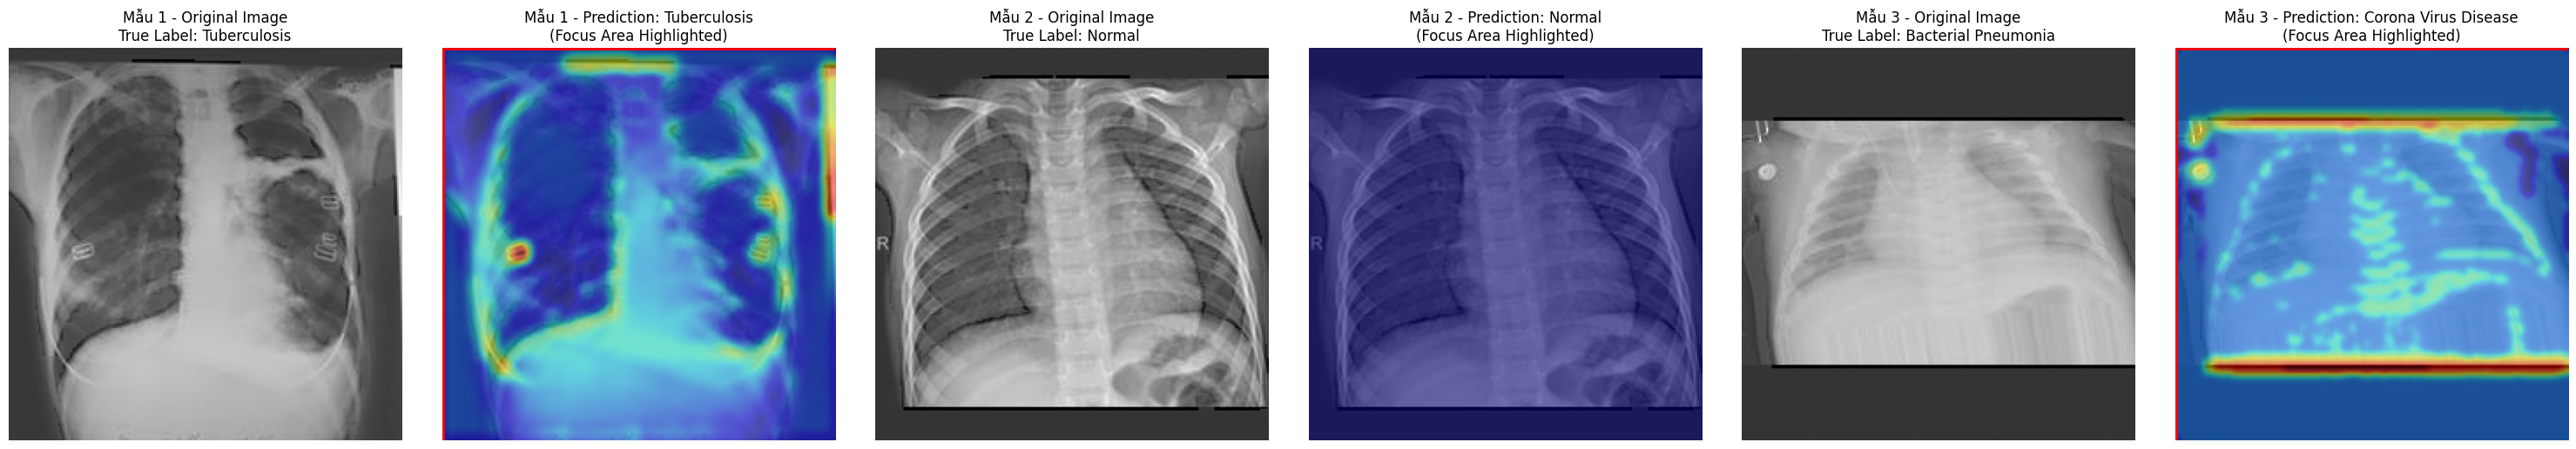

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Định nghĩa số lượng lớp
classes = ["Normal", "Bacterial Pneumonia", "Corona Virus Disease", "Tuberculosis", "Viral Pneumonia"]
num_classes = len(classes)

# Hàm tính ngưỡng Otsu bằng TensorFlow
def otsu_threshold(image):
    image = (image - tf.reduce_min(image)) / (tf.reduce_max(image) - tf.reduce_min(image))
    image_scaled = image * 255.0
    hist = tf.histogram_fixed_width(image_scaled, [0.0, 256.0], nbins=256)
    hist = tf.cast(hist, tf.float32)
    bin_centers = tf.range(256, dtype=tf.float32)
    total = tf.reduce_sum(hist)
    weight_background = tf.cumsum(hist)
    weight_foreground = total - weight_background
    weight_background = tf.where(weight_background == 0, tf.ones_like(weight_background), weight_background)
    weight_foreground = tf.where(weight_foreground == 0, tf.ones_like(weight_foreground), weight_foreground)
    mean_background = tf.cumsum(hist * bin_centers) / weight_background
    mean_foreground = (tf.reduce_sum(hist * bin_centers) - tf.cumsum(hist * bin_centers)) / weight_foreground
    class_variance = weight_background * weight_foreground * (mean_background - mean_foreground) ** 2
    threshold = tf.argmax(class_variance)
    binary_mask = tf.cast(image_scaled >= tf.cast(threshold, tf.float32), tf.float32)
    return binary_mask

# Hàm tách nền bằng TensorFlow thuần
def preprocess_image(image, label, augment=False):
    image = tf.image.resize(image, [224, 224])
    image = (image - tf.reduce_mean(image)) / tf.math.reduce_std(image)
    img_for_threshold = image[:, :, 0]
    binary_mask = otsu_threshold(img_for_threshold)
    kernel = tf.ones((5, 5, 1), dtype=tf.float32)
    binary_mask = tf.expand_dims(binary_mask, axis=0)
    binary_mask = tf.expand_dims(binary_mask, axis=-1)
    # Opening: erosion rồi dilation để loại bỏ nhiễu
    binary_mask = tf.nn.erosion2d(binary_mask, filters=kernel, strides=(1, 1, 1, 1), padding="SAME", data_format="NHWC", dilations=(1, 1, 1, 1))
    binary_mask = tf.nn.dilation2d(binary_mask, filters=kernel, strides=(1, 1, 1, 1), padding="SAME", data_format="NHWC", dilations=(1, 1, 1, 1))
    binary_mask = tf.squeeze(binary_mask, axis=0)
    binary_mask = tf.expand_dims(binary_mask, axis=0)
    binary_mask = tf.nn.dilation2d(binary_mask, filters=kernel, strides=(1, 1, 1, 1), padding="SAME", data_format="NHWC", dilations=(1, 1, 1, 1))
    binary_mask = tf.squeeze(binary_mask, axis=0)
    mask = binary_mask
    image = image * mask
    image.set_shape([224, 224, 1])
    return image, label

# Hàm phân tích TFRecord
def parse_tfrecord_fn(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'channels': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_raw(example['image'], tf.float32)
    height = tf.cast(example['height'], tf.int32)
    width = tf.cast(example['width'], tf.int32)
    channels = tf.cast(example['channels'], tf.int32)

    image = tf.reshape(image, [height, width, channels])
    if tf.math.equal(channels, 1):
        pass
    else:
        tf.print(f"Warning: Channels is {channels}, forcing to 1")
        image = tf.reduce_mean(image, axis=-1, keepdims=True)

    image = tf.ensure_shape(image, [None, None, 1])
    label = tf.cast(example['label'], tf.int32)
    return image, label

# Hàm tạo dataset từ TFRecord
def create_tf_dataset(tfrecord_path, batch_size=32, shuffle=False, augment=False):
    dataset = tf.data.TFRecordDataset(tfrecord_path, compression_type="GZIP")
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=5000)

    dataset = dataset.map(
        lambda x, y: preprocess_image(x, y, augment=augment),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    for images, labels in dataset.take(1):
        print(f"Shape of images after preprocess: {images.shape}")

    return dataset

# Load dataset (chỉ cần tập test cho Grad-CAM)
output_dir = "/content/drive/MyDrive/Colab Notebooks/LungCancerDx/TFRecords"
test_dataset = create_tf_dataset(os.path.join(output_dir, "test_dataset.tfrecord"), batch_size=32, shuffle=True, augment=False)  # Giữ shuffle=True để tìm batch tốt hơn

# Tải mô hình đã lưu
model_path = '/content/drive/MyDrive/Colab Notebooks/LungCancerDx/lung_cnn_model_v2.keras'
model = models.load_model(model_path)
model.summary()

# Đánh giá mô hình trên tập test để lấy độ chính xác tổng thể
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Độ chính xác tổng thể trên tập test: {test_accuracy * 100:.2f}%")

# Lấy một batch từ tập test để kiểm tra Grad-CAM
img_array, true_label = next(iter(test_dataset.take(1)))
print(f"Hình dạng của img_array: {img_array.shape}")

# Dự đoán
predictions = model.predict(img_array)
num_samples_to_display = min(3, img_array.shape[0])  # Hiển thị tối đa 3 mẫu

# Định nghĩa hàm Grad-CAM
def get_gradcam_heatmap(model, img_array, layer_name, class_index):
    if layer_name not in [layer.name for layer in model.layers]:
        raise ValueError(f"Lớp '{layer_name}' không tồn tại trong mô hình. Vui lòng kiểm tra tóm tắt mô hình để tìm tên lớp chính xác.")

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_outputs)[0]
    # Kiểm tra gradient
    print(f"Max gradient value: {tf.reduce_max(grads)}")
    print(f"Min gradient value: {tf.reduce_min(grads)}")
    # Làm mềm gradient để tăng giá trị heatmap
    grads = tf.abs(grads)  # Lấy giá trị tuyệt đối để tránh triệt tiêu
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1)
    # Chuẩn hóa heatmap và xử lý giá trị không hợp lệ
    heatmap = tf.maximum(heatmap, 0)  # Đảm bảo không có giá trị âm
    # Chuẩn hóa Min-Max
    max_val = tf.reduce_max(heatmap)
    min_val = tf.reduce_min(heatmap)
    if max_val == min_val:
        heatmap = tf.zeros_like(heatmap)  # Nếu max_val = min_val, giữ heatmap toàn 0
    else:
        heatmap = (heatmap - min_val) / (max_val - min_val + 1e-6)  # Chuẩn hóa
    heatmap = tf.where(tf.math.is_finite(heatmap), heatmap, 0.0)  # Thay NaN/inf bằng 0
    return heatmap

# Hiển thị Grad-CAM cho 3 mẫu đầu tiên
layer_name = 'conv2d_block2_2'  # Thử lớp nông hơn
plt.figure(figsize=(30, 5))  # Kích thước lớn để hiển thị ngang

for i in range(num_samples_to_display):
    # Lấy thông tin cho mẫu thứ i
    img = img_array[i:i+1]  # Giữ batch dimension
    true_label_i = true_label[i].numpy()
    predicted_class_i = np.argmax(predictions[i])

    print(f"\nMẫu {i+1}:")
    print(f"Nhãn thật: {true_label_i} ({classes[true_label_i]})")
    print(f"Dự đoán: {predicted_class_i} ({classes[predicted_class_i]})")

    # Tính toán heatmap
    try:
        heatmap = get_gradcam_heatmap(model, img, layer_name, predicted_class_i)
        print("Tính toán heatmap thành công!")
        print(f"Shape của heatmap: {heatmap.shape}")
        # Kiểm tra giá trị của heatmap
        heatmap_np = heatmap.numpy()
        print(f"Min value of heatmap: {np.min(heatmap_np)}")
        print(f"Max value of heatmap: {np.max(heatmap_np)}")
        print(f"Sample values of heatmap: {heatmap_np[0, :5]}")
    except ValueError as e:
        print(e)
        print("Vui lòng cập nhật layer_name trong get_gradcam_heatmap và thử lại.")
        break
    except Exception as e:
        print(f"Lỗi khi tính toán heatmap: {e}")
        break

    # Resize heatmap bằng tf.image.resize
    heatmap = tf.expand_dims(heatmap, axis=0)  # Thêm batch dimension
    heatmap = tf.expand_dims(heatmap, axis=-1)  # Thêm channel dimension
    heatmap_resized = tf.image.resize(heatmap, [224, 224], method='bilinear')
    heatmap_resized = tf.squeeze(heatmap_resized, axis=[0, -1])  # Loại bỏ batch và channel dimension
    heatmap_resized = heatmap_resized.numpy()

    # Làm mịn heatmap
    heatmap_resized = cv2.GaussianBlur(heatmap_resized, (9, 9), 0)  # Tăng độ làm mịn

    # Chuẩn hóa lại heatmap_resized
    heatmap_resized = np.maximum(heatmap_resized, 0)
    max_val = np.max(heatmap_resized)
    if max_val > 0:
        heatmap_resized = heatmap_resized / max_val

    # Tạo ngưỡng và tìm đường viền
    heatmap_normalized = np.uint8(255 * heatmap_resized)
    _, thresh = cv2.threshold(heatmap_normalized, 30, 255, cv2.THRESH_BINARY)  # Tăng ngưỡng lên 30
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Hiển thị hình ảnh gốc
    plt.subplot(1, 6, 2 * i + 1)  # 1 hàng, 6 cột, cột 1, 3, 5 cho ảnh gốc
    plt.imshow(img_array[i, :, :, 0], cmap='gray')
    plt.title(f'Mẫu {i+1} - Original Image\nTrue Label: {classes[true_label_i]}')
    plt.axis('off')

    # Hiển thị hình ảnh với heatmap và đường viền
    plt.subplot(1, 6, 2 * i + 2)  # 1 hàng, 6 cột, cột 2, 4, 6 cho ảnh với heatmap
    plt.imshow(img_array[i, :, :, 0], cmap='gray')
    plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)

    for contour in contours:
        if cv2.contourArea(contour) > 300:  # Tăng điều kiện diện tích lên 300
            x, y, w, h = cv2.boundingRect(contour)
            plt.gca().add_patch(plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none'))

    plt.title(f'Mẫu {i+1} - Prediction: {classes[predicted_class_i]}\n(Focus Area Highlighted)')
    plt.axis('off')

plt.tight_layout()
plt.show()